## 1. IMPORTATION DES BIBLIOTHÈQUES


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')
import random
import shutil
import zipfile



## 2. CONFIGURATION ET CHEMINS

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
DATA_PATH = 'D:\\Formation DAH\\Deploiement_MLOps\\Projet_final_DOBE\\data\\New Plant Diseases Dataset(Augmented)'
NUM_CLASSES = len(os.listdir(DATA_PATH))


In [4]:
print(os.listdir(DATA_PATH))

['train', 'valid']


## 3. EXPLORATION DES DONNÉES

In [5]:
# Lister les classes
train_dir = os.path.join(DATA_PATH,'train')
valid_dir = os.path.join(DATA_PATH,'valid')

classes = sorted(os.listdir(train_dir))

print(f"\nNombre de classes: {len(classes)}")
print(f"\nPremières classes:\n{classes[:5]}")


Nombre de classes: 38

Premières classes:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


In [6]:
train_dir = os.path.join(DATA_PATH, 'train')
classes = sorted(os.listdir(train_dir))


In [7]:
# Compter les images par classe
class_counts = {}
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[cls] = count

print(f"\nTotal d'images d'entraînement: {sum(class_counts.values())}")



Total d'images d'entraînement: 140590


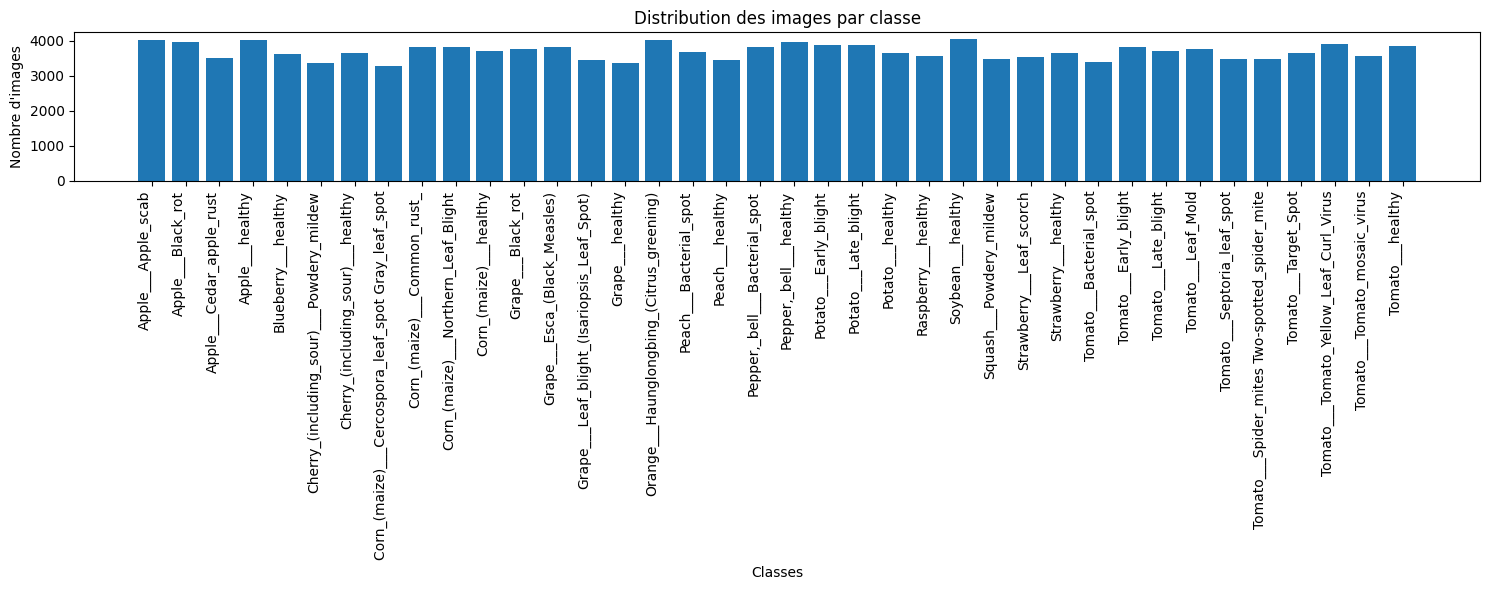

In [8]:
# Visualiser la distribution
plt.figure(figsize=(15, 6))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des images par classe')
plt.xticks(range(len(class_counts)), class_counts.keys(), rotation=90, ha='right')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. VISUALISATION D'ÉCHANTILLONS D'IMAGES


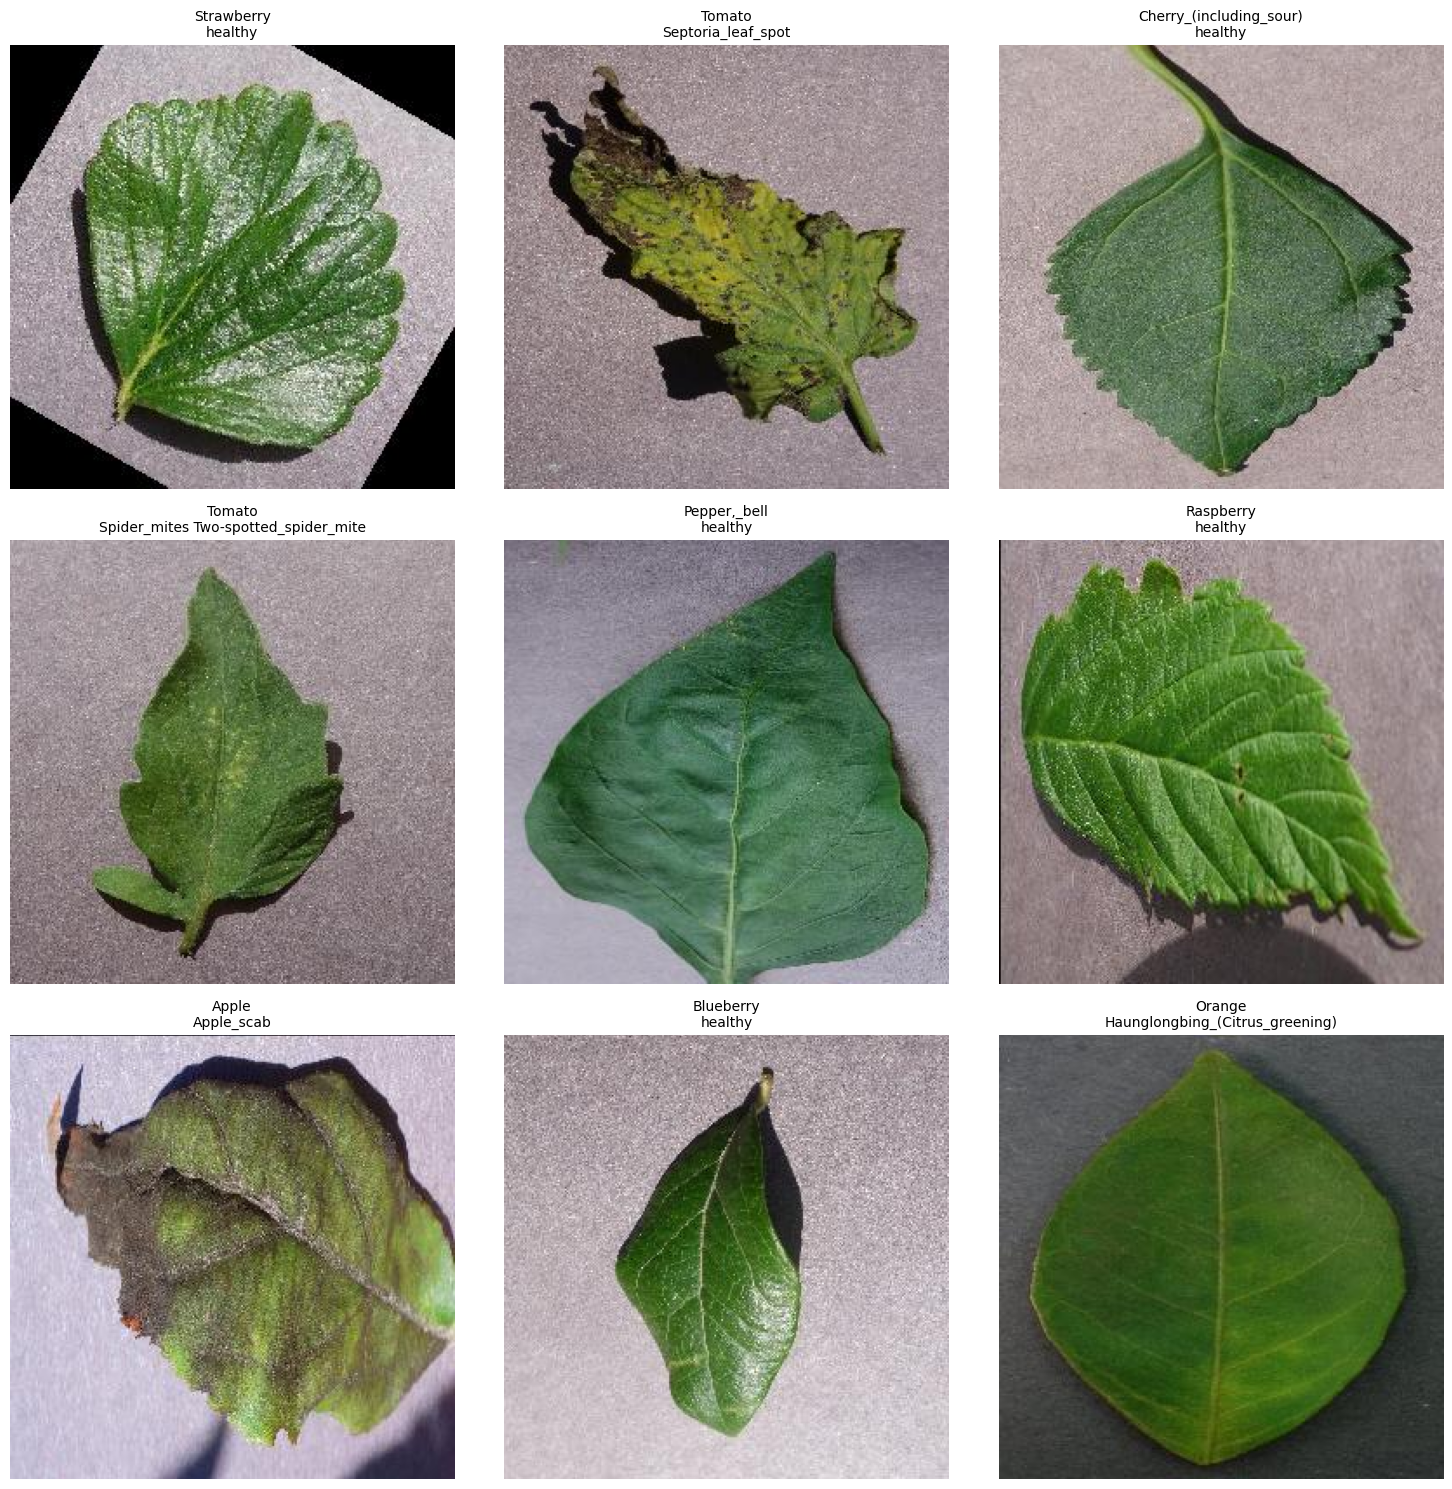

In [9]:
def visualize_samples(data_dir, classes_to_show=9):
    """Affiche des échantillons d'images"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    selected_classes = np.random.choice(classes, min(classes_to_show, len(classes)), replace=False)
    
    for idx, cls in enumerate(selected_classes):
        class_path = os.path.join(data_dir, cls)
        images = os.listdir(class_path)
        if images:
            img_path = os.path.join(class_path, np.random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[idx].imshow(img)
            axes[idx].set_title(cls.replace('___', '\n'), fontsize=10)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_samples(train_dir)

## 5. PRÉTRAITEMENT ET AUGMENTATION DES DONNÉES

In [10]:
# Générateur d'augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Générateur pour la validation (seulement rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Créer les générateurs
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"\nNombre de classes: {num_classes}")
print(f"Images d'entraînement: {train_generator.samples}")
print(f"Images de validation: {valid_generator.samples}")


Found 140590 images belonging to 38 classes.
Found 35144 images belonging to 38 classes.

Nombre de classes: 38
Images d'entraînement: 140590
Images de validation: 35144


In [11]:
# Sauvegarder le mapping des classes
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)


Exemples d'images augmentées:


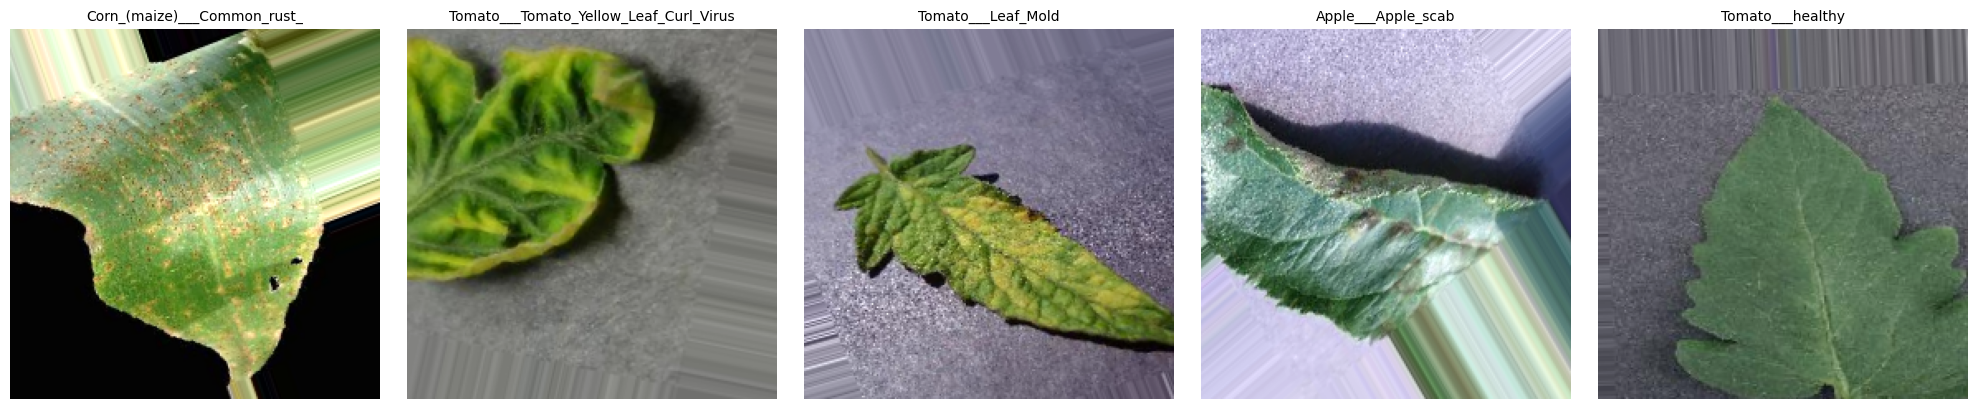

In [12]:
# Visualiser l'augmentation
def show_augmentation(generator, num_images=5):
    """Affiche des exemples d'augmentation"""
    batch_images, batch_labels = next(generator)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(batch_images[i])
        label_idx = np.argmax(batch_labels[i])
        axes[i].set_title(f"{class_names[label_idx]}", fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('augmented_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nExemples d'images augmentées:")
show_augmentation(train_generator)

## 6. CONSTRUCTION DU MODÈLE (TRANSFER LEARNING)

In [13]:
def build_model(num_classes):
    """Construit un modèle CNN avec Transfer Learning (MobileNetV2)"""
    
    # Charger le modèle pré-entraîné
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Geler les couches de base
    base_model.trainable = False
    
    # Créer le modèle
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_model(num_classes)

In [14]:
# Compiler le modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,063,142 (11.68 MB)

 Trainable params: 801,062 (3.06 MB)

 Non-trainable params: 2,262,080 (8.63 MB)

None


## 7. CALLBACKS ET ENTRAÎNEMENT

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [17]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7300 - loss: 0.8914 - top_3_accuracy: 0.8967
Epoch 1: val_accuracy improved from None to 0.91515, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 7765s 2s/step - accuracy: 0.7965 - loss: 0.6433 - top_3_accuracy: 0.9422 - val_accuracy: 0.9151 - val_loss: 0.2578 - val_top_3_accuracy: 0.9876 - learning_rate: 0.0010
Epoch 2/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8449 - loss: 0.4757 - top_3_accuracy: 0.9663
Epoch 2: val_accuracy improved from 0.91515 to 0.91936, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5989s 1s/step - accuracy: 0.8491 - loss: 0.4620 - top_3_accuracy: 0.9674 - val_accuracy: 0.9194 - val_loss: 0.2390 - val_top_3_accuracy: 0.9879 - learning_rate: 0.0010
Epoch 3/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8587 - loss: 0.4297 - top_3_accuracy: 0.9709
Epoch 3: val_accuracy improved from 0.91936 to 0.93438, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6626s 2s/step - accuracy: 0.8615 - loss: 0.4203 - top_3_accuracy: 0.9719 - val_accuracy: 0.9344 - val_loss: 0.1962 - val_top_3_accuracy: 0.9911 - learning_rate: 0.0010
Epoch 4/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8685 - loss: 0.4015 - top_3_accuracy: 0.9742
Epoch 4: val_accuracy improved from 0.93438 to 0.93535, saving model to best_model.h5


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6194s 1s/step - accuracy: 0.8693 - loss: 0.3981 - top_3_accuracy: 0.9746 - val_accuracy: 0.9354 - val_loss: 0.2001 - val_top_3_accuracy: 0.9912 - learning_rate: 0.0010
Epoch 5/5
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8736 - loss: 0.3819 - top_3_accuracy: 0.9764
Epoch 5: val_accuracy did not improve from 0.93535
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 6309s 1s/step - accuracy: 0.8751 - loss: 0.3782 - top_3_accuracy: 0.9767 - val_accuracy: 0.9340 - val_loss: 0.1921 - val_top_3_accuracy: 0.9927 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


## 8. VISUALISATION DES RÉSULTATS

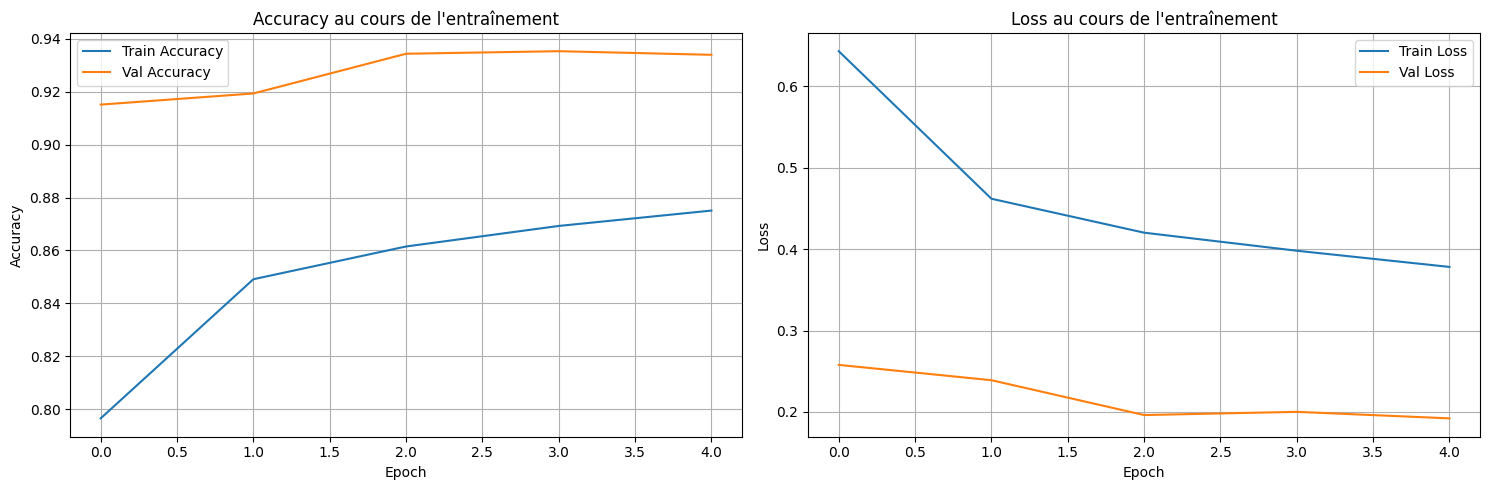

In [18]:
def plot_training_history(history):
    """Visualise l'historique d'entraînement"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Accuracy au cours de l\'entraînement')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Loss au cours de l\'entraînement')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)


## 9. ÉVALUATION DU MODÈLE

In [19]:
# Évaluer sur le set de validation
val_loss, val_acc, val_top3 = model.evaluate(valid_generator)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Top-3 Accuracy: {val_top3:.4f}")

# Prédictions
valid_generator.reset()
y_pred = model.predict(valid_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = valid_generator.classes

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 755s 687ms/step - accuracy: 0.9340 - loss: 0.1921 - top_3_accuracy: 0.9927

Validation Loss: 0.1921
Validation Accuracy: 0.9340
Top-3 Accuracy: 0.9927
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 760s 689ms/step


In [20]:
# Rapport de classification
print("\nRapport de Classification (Top 10 classes):")
report = classification_report(y_true, y_pred_classes, target_names=[class_names[i] for i in range(num_classes)])
print(report[:1000])  # Afficher seulement les premières lignes



Rapport de Classification (Top 10 classes):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.94      0.95      1008
                                 Apple___Black_rot       0.97      0.98      0.97       994
                          Apple___Cedar_apple_rust       0.99      0.97      0.98       880
                                   Apple___healthy       0.98      0.96      0.97      1004
                               Blueberry___healthy       0.98      0.94      0.96       908
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.98       842
                 Cherry_(including_sour)___healthy       0.96      0.99      0.98       912
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.89      0.90       820
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       954
               Corn_(maize)___Nort

In [21]:
# Matrice de confusion (simplifiée pour les 10 premières classes)
cm = confusion_matrix(y_true, y_pred_classes)
print(f"\nMatrice de confusion créée: {cm.shape}")


Matrice de confusion créée: (38, 38)


# 9. SAUVEGARDER LE MODÈLE

In [ ]:
# Sauvegarder le modèle final
model.save('models\\plant_disease_model.h5')
print("✓ Modèle sauvegardé: plant_disease_model.h5")



✓ Modèle sauvegardé: plant_disease_model.h5


In [27]:
import os

os.makedirs("models", exist_ok=True)
model.save("models/plant_disease_model.keras")
print("✓ Modèle sauvegardé !")


✓ Modèle sauvegardé !


In [24]:
# Sauvegarder l'historique
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Historique sauvegardé: training_history.pkl")

✓ Historique sauvegardé: training_history.pkl
